In [1]:
%load_ext autoreload
%autoreload 2

Презентация показывает основные концепции, используемые в библиотеке в ознакомительном формате без тонкостей реализации и т.д.

## Sampler (идея, цель, примеры использования)

### Идея:
- обертка над всеми данными, хранит в себе train, oos, oot (и признаки, таргет)
- бесконечный источник данных из того же распределения, что и данные пришедшие на валидацию. Реализовываться это может подкапотом как угодно (скорее всего KFold, Bootstraping или Resampling)

### Цель:

у некоторых моделей есть ограничения на *resampling* данных (разбивать на train и oos не строки, а людей, определяя их по ИНН). Данный класс позволяет абстрагироваться от этих тонкостей, предоставляя единый интерфейс.


### Типичные примеры исполльзования

In [2]:
# Создаем данные
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from IPython.display import display


X, y = make_classification(n_samples=1000, n_classes=2,
                           n_features=3, n_informative=2,
                           n_redundant=0, random_state=0)
X = pd.DataFrame(X)
y = pd.Series(y)
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

print('Исходные данные: ')
display(X_train[:3])
display(X_test[:3])

Исходные данные: 


,0,1,2
56,1.103065,1.572330,0.815087
165,-0.895764,-1.381745,-0.839634
634,-0.993119,-0.913595,-0.902592


,0,1,2
402,1.290400,-0.842572,-1.150631
702,-2.549207,2.254284,-0.725572
915,2.028431,-1.000760,2.055941


In [3]:
# Создаем sampler
from sbe_vallib import SupervisedSampler

sampler = SupervisedSampler(train={'X': X_train, 'y_true': y_train},
                            oos={'X': X_test, 'y_true': y_test},
                            oot=None)

получаем данные по атрибуту ```train, oos, oot``` (под капотом там лежат ```property```)

In [4]:
display(sampler.train['X'][:4])
display(sampler.oos['X'][:4])

,0,1,2
56,1.103065,1.572330,0.815087
165,-0.895764,-1.381745,-0.839634
634,-0.993119,-0.913595,-0.902592
330,-0.789695,0.374155,-1.335048


,0,1,2
402,1.290400,-0.842572,-1.150631
702,-2.549207,2.254284,-0.725572
915,2.028431,-1.000760,2.055941
436,0.203536,-0.341982,-0.648361


In [5]:
# Фиксируем seed и способ генерации новой выборки
sampler.set_state(seed=5, gen_method='bootstrap')

#теперь по аттрибутам train, oos, oot у нас новые выборки, полученные бутстрапированием исходных
display(sampler.train['X'][:4])
display(sampler.oos['X'][:4])


,0,1,2
831,-1.139646,1.409952,-1.221395
801,-3.107342,-0.018767,-0.257885
572,0.990155,0.115665,-1.001089
245,1.768178,-0.429224,2.631209


,0,1,2
964,0.608856,-0.222959,-0.616306
726,-1.124299,-0.628981,-1.141971
540,-0.903690,1.344074,-0.456647
727,-0.965926,-3.116857,-1.305269


In [6]:
# Перезагружаем состояние sampler, чтобы получать снова исходные выборки
sampler.reset()

display(sampler.train['X'][:4])
display(sampler.oos['X'][:4])

,0,1,2
56,1.103065,1.572330,0.815087
165,-0.895764,-1.381745,-0.839634
634,-0.993119,-0.913595,-0.902592
330,-0.789695,0.374155,-1.335048


,0,1,2
402,1.290400,-0.842572,-1.150631
702,-2.549207,2.254284,-0.725572
915,2.028431,-1.000760,2.055941
436,0.203536,-0.341982,-0.648361


## Scorer (идея, цель, примеры использования)

### Идея:

Идея этого класса - посчитать скопом заранее заданные метрики при вызове метода ```scorer.calc_metrics()```

### Цель:

Причина появления: модели могут оцениваются самыми разными способами, все не уложить в тип ```func(y_true, y_pred)```.Например *YOLO* или же в табличных данных ключевая метрика это сумма на ```train``` и ```oos```. С помощью этого класса абстрагируемся от этого в через подачу в скорер всего ```scorer.calc_metrics(model, sampler, **something_else)```, оставляя реализацию в нестандартных случаях на валидатора. 


In [7]:
# создаем scorer
from sbe_vallib import BinaryScorer
from sbe_vallib.utils.metrics import BINARY_METRICS

scorer = BinaryScorer(metrics=BINARY_METRICS, cutoff=0.1)

In [8]:
# есть метрики, которые работают с классом, а есть которые работают с вероятностями
# scorer внутри себя регулирует, что куда подать
list(BINARY_METRICS.keys())

['accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'gini']

### Типичные примеры исполльзования

In [9]:
# для начала создадим и обучим модель

from sklearn.linear_model import LogisticRegression

sampler.reset()
model = LogisticRegression().fit(sampler.train['X'], sampler.train['y_true'])

In [10]:
scorer.calc_metrics(model=model, sampler=sampler, data_type='oos')

{'accuracy_score': 0.87,
 'precision_score': 0.8,
 'recall_score': 0.9866666666666667,
 'f1_score': 0.8835820895522389,
 'gini': 0.9533333333333336}

## Test (идея, цель, примеры использования)

### Идея:

Функция, которая реализует подсчет теста и его оформление. На эту функцию накладываются ограничения на сигнатуру: 

- функция как минимум должна принимать параметры ```model, scorer, sampler, precomputed: dict=None, **kwargs``` 
- функция должна выдать результат работы в следующем формате (привет SberDS)
    ```
    {
        "semaphore": str one of {"gray", "green", "yellow", "red"},
        "result_dict": python object,
        "result_dataframes": List[pd.DataFrame],
        "result_plots": List[PIL.Image],
    }
    ```
    где,
    - "semaphore" -- светофор выставленный за тест
    - "result_dict" -- python object, который валидатор посчитает полезным для дальнейшего использования
    - "result_dataframes" -- список таблиц, которые будут отражены в агрегированном excel файле
    - "result_plots" -- список картинок, которые будут отражены в агрегированном excel файле.
- ```sampler``` это единственный источник данных
- ```precomputed``` это Dict, который служит для обмена предпосчитанными значениями между тестами (зачем 5 раз считать метрику на oos, если можно 1 раз посчитать и записать это значение в dict)


### Цель:

Провести тест


In [11]:
# напишем какой-то тупой тест
# По длине train выставляет светофор

def custom_test(model, scorer, sampler, threshold = 1, precomputed=None, **kwargs):
    semaphore = 'green'
    if len(sampler.train['X']) < threshold:
        semaphore = 'red'
    
    df_table = pd.DataFrame({'len': [len(sampler.train['X'])],
                             'semaphore': semaphore})
    
    return {
        "semaphore": semaphore,
        "result_dict": {'train_shape':sampler.train['X'].values.shape},
        "result_dataframes": [df_table],
        "result_plots": [],
    }

custom_test(model, scorer, sampler, threshold=5, r_u_angry='True')

{'semaphore': 'green',
 'result_dict': {'train_shape': (700, 3)},
 'result_dataframes': [   len semaphore
  0  700     green],
 'result_plots': []}

## Pipeline (идея, цель, примеры использования)

### Идея:

Отражение понятия методики в нашей бибилиотеке. То есть ```Pipeline``` это список тестов с указанными параметрами и дополнительными метаданными для формирования отчета (*цель теста, интерпретация, способ агрегации блоков*).

### Цель:

Капсулировать всю информацию из методички


## Реализация:

```Pipeline``` - это excel-файл с двумя страницами
- первая страница -- информация о тестах
- вторая страница -- информация о блоках.

In [12]:
pd.read_excel("../src/sbe_vallib/table/pipelines/Config_31.xlsx", sheet_name="tests_config")

/Users/azatsultanov/Programming/vallib/vallib_env/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,import_path,test_key,block_key,informative,Название блока,Название,Цель,Интерпретация,Границы красный,Границы желтый,Границы зеленый,params
0,sbe_vallib.table.data_quality.test_psi_factor....,test_factor_psi,data_quality,0,Качество данных,Тест 1.2 Анализ однородности выборок out-of-sa...,Убедиться в однородности выборки (в разрезе фа...,Высокое значение PSI свидетельствует о различи...,NaN,"PSI ≥ 0,2","PSI < 0,2","{""merge_upto_quantile"": 0.05,\n ""rounding_prec..."
1,sbe_vallib.table.model_quality.test_ci.test_ci,test_ci,model_quality,1,Качество модели,Тест 2.2 Доверительный интервал ключевой метри...,Наглядно изобразить уровень статистической пог...,Данный тест позволяет оценить фактический разб...,NaN,NaN,NaN,"{'metric_name': 'gini',\n 'n_iter': 200,\n 'ge..."
2,sbe_vallib.table.model_quality.test_key_metric...,test_key_metric,model_quality,0,Качество модели,Тест 2.1 Анализ ключевой метрики качества (Gin...,Тест проводится для определения способности мо...,"Чем выше значение коэффициента Gini, тем лучше...","gini < 0,2",0.2 ≤ gini ≤ 0.4,gini > 0.4,"{'metric_name': 'gini', 'thresholds': (0.2, 0..."
3,sbe_vallib.table.stability.test_key_metric_sta...,test_key_metric_stability,stability,0,Стабильность модели,Тест 5.1 Анализ стабильности модели на выборка...,Оценить стабильность модели по ключевой метрик...,"Чем слабее падает коэффициент Gini, тем стабил...",Абсолютное снижение более 25 п. п. и относите...,Абсолютное снижение более 15 п. п. И относител...,Абсолютное снижение менее 15 п. п. ИЛИ относит...,"{'metric_name': 'gini', 'abs_thresholds': (0...."


In [13]:
pd.read_excel("../src/sbe_vallib/table/pipelines/Config_31.xlsx", sheet_name="agg_config")

,block_key,func
0,data_quality,sbe_vallib.validation.worst_semaphore
1,model_quality,sbe_vallib.validation.worst_semaphore
2,calibration,sbe_vallib.validation.worst_semaphore
3,specification,sbe_vallib.validation.worst_semaphore
4,stability,sbe_vallib.validation.worst_semaphore


Excel таблицы парсят вот в такой json, в Validation можно передавать excel и dict. На excel приятно смотреть, а dict приятней редачить

In [30]:
from sbe_vallib.parser import parse_pipeline

parse_pipeline("../src/sbe_vallib/table/pipelines/Config_31.xlsx")

/Users/azatsultanov/Programming/vallib/vallib_env/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


{'test_factor_psi': {'import_path': 'sbe_vallib.table.data_quality.test_psi_factor.test_factor_psi',
  'block_key': 'data_quality',
  'params': {'merge_upto_quantile': 0.05,
   'rounding_precision_bins': 5,
   'discr_uniq_val': 10,
   'discr_val_share': 0.8,
   'threshold': (0.2, 10000000)},
  'informative': 0},
 'test_ci': {'import_path': 'sbe_vallib.table.model_quality.test_ci.test_ci',
  'block_key': 'model_quality',
  'params': {'metric_name': 'gini',
   'n_iter': 200,
   'gen_method': 'resampling',
   'quantile': 0.95},
  'informative': 1},
 'test_key_metric': {'import_path': 'sbe_vallib.table.model_quality.test_key_metric.test_key_metric',
  'block_key': 'model_quality',
  'params': {'metric_name': 'gini',
   'thresholds': (0.2, 0.4),
   'greater_is_better': True,
   'data_type': 'oos'},
  'informative': 0},
 'test_key_metric_stability': {'import_path': 'sbe_vallib.table.stability.test_key_metric_stability.test_key_metric_stability',
  'block_key': 'stability',
  'params': {'metr

## Validation (идея, цель, примеры использования)

### Идея:

Запуск всех тестов из списка и аггрегация их результатов.

### Цель:

Удобный запуск тестов


<img src="./images/uml_vallib.jpg" alt="fishy" class="bg-primary mb-1" width="500px">

Можно добавлять в кастомные тесты в провдении валидации без внесения их в excel,
просто напишем для теста dict на примере того который получается после парсинга excel

```
{'test_key': {'block': 'test_block', 'callable': func, 'params': {'a': 4}}, 'informative': 0}
```

In [23]:
# способ прокидывания custim_test'ов в validation

from sbe_vallib import Validation


custom_tests = {
    "custom_1": {"block": "data_quality", "callable": custom_test, "params": {"threshold": 5000}}
}


validor = Validation(model,
                     sampler,
                     scorer,
                     custom_tests=custom_tests,
                     pipeline="../src/sbe_vallib/table/pipelines/Config_31.xlsx")
res = validor.validate()
print('done')

/Users/azatsultanov/Programming/vallib/vallib_env/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Traceback (most recent call last):
  File "/Users/azatsultanov/Programming/vallib/repo/vallib/src/sbe_vallib/validation.py", line 70, in validate
    tests_result[test_name] = test_function(
  File "/Users/azatsultanov/Programming/vallib/repo/vallib/src/sbe_vallib/table/stability/test_key_metric_stability.py", line 57, in test_key_metric_stability
    metrics_oot = get_source_metrics(
  File "/Users/azatsultanov/Programming/vallib/repo/vallib/src/sbe_vallib/table/model_quality/test_key_metric.py", line 11, in get_source_metrics
    if 'y_pred' not in data:
TypeError: argument of type 'NoneType' is not iterable

done


In [24]:
list(res.keys())

['test_factor_psi',
 'test_ci',
 'test_key_metric',
 'test_key_metric_stability',
 'custom_1']

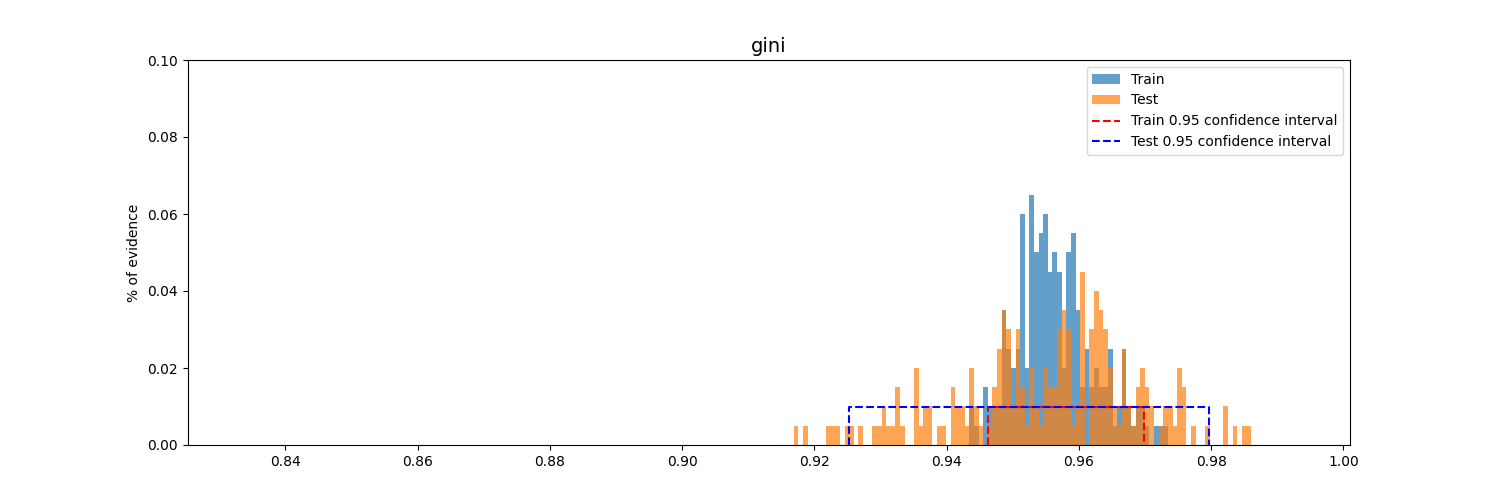

In [25]:
res['test_ci']['result_plots'][0]

In [26]:
res['test_key_metric_stability']['semaphore']

'Traceback (most recent call last):\n  File "/Users/azatsultanov/Programming/vallib/repo/vallib/src/sbe_vallib/validation.py", line 70, in validate\n    tests_result[test_name] = test_function(\n  File "/Users/azatsultanov/Programming/vallib/repo/vallib/src/sbe_vallib/table/stability/test_key_metric_stability.py", line 57, in test_key_metric_stability\n    metrics_oot = get_source_metrics(\n  File "/Users/azatsultanov/Programming/vallib/repo/vallib/src/sbe_vallib/table/model_quality/test_key_metric.py", line 11, in get_source_metrics\n    if \'y_pred\' not in data:\nTypeError: argument of type \'NoneType\' is not iterable\n'